# Great Lunar Lander with DQN

**The Team:**
* Class: DAAA/FT/2B/06
* **Member 1**:
    * Name: Haja Amir Rahman
* **Member 2**:
    * Name: Justin Wong

# OpenAI: Lunar Lander V2

<img src="https://miro.medium.com/max/1400/1*W1t--mEISwFTJNXi-qk7vw.png" width="500">

Image from Medium

# Goal of Notebook
The goal of the notebook is to create a Reinforcement Learning model that can land an agent in the Lunar Lander gym environment.

# Introduction

**Reinforcement Learning**

Reinforcement Learning or RL is subset of machine learning that deals with how an agent in an environment choose a sequence of actions in order to maximise a numerical reward signal. It can also be said that RL is trying to find a balance between exploration and exploitation. Exploration is a type of decision where the agent chooses to pick an action that it would not have done. In contrast, exploitation is when the agent follows what it has always done.

**OpenAI GYM**

OpenAI GYM is a toolkit for developing and comparing reinforcement learning algorithms. They have a gym library that contains a variety of reinforcement learning tasks from walking in 3D space to playing arcade games like PacMan. These environments have a shared and easy-to-use interface where researchers and developers can train and compare agents using different algorithms.

**OpenAI Gym Environment: LunarLander-v2**

<img src="https://wingedsheep.com/content/images/2020/08/lunarlander.gif" width="500">

Lunar Lander is one of OpenAI's gym environment where the agent is a lunar lander that tries to land on a landing pad at coordinate (0,0). These coordinate are the first 2 numbers in the state vector.

There are a total of 4 discrete actions that the lander can do:

1. Do nothing
2. Fire left orientation engine
3. Fire main engine
4. Fire right orientation engine

There are a total of 8 observation space:

1. The coordinates of the lander in x
2. The coordinates of the lander in y
3. Its linear velocities in x
4. Its linear velocities in y
5. Its angle
6. Its angular velocity
7. If left leg is in contact with the ground
8. If right leg is in contact with the ground

Reward system of Lunar Lander:

* Moving from the top of the screen to the landing pad at zero speed can range from 100 to 140 points.
* If the lander moves away from the landing pad, it loses back the landing points.
* The episode finishes if the lander crashes (receives -100 points) or comes to a rest (receives 100 points).
* Each leg ground contact is an additional 10 points.
* Firing main engine -0.3 reward per step.

From the above, we can conclude that the best episode would be the one where the lander lands (**+20** for legs contact) and comes to rest (**+100** for rest) on the center of the landing pad at zero speed (**+140** for landing) with the least steps (**+200** - (count_main_engine_fire * 0.3)).

### Importing important modules, dependencies and logging and initialising wandb

In [1]:
import numpy as np
import gym
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
import matplotlib.pyplot as plt
import wandb
wandb.login()
wandb.init(project="RL", entity="amirrahman19")
#what probs does sarsa solve
#what are the pros and cons of sarsa
#how does sarsa work

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amirrahman19. Use `wandb login --relogin` to force relogin


In [2]:
env = gym.make('LunarLander-v2')

## Creating the Deep Neural Network

In [3]:
class Network(nn.Module):
    
    def __init__(self, state_num , action_num, hidden_layer):
        
        super(Network, self).__init__()
        self.input_layer = nn.Linear(state_num, hidden_layer)
        self.h1_layer = nn.Linear(hidden_layer, hidden_layer)
        self.h2_layer = nn.Linear(hidden_layer, hidden_layer)
        self.output_layer = nn.Linear(hidden_layer, action_num)
        

    def forward(self, state):
        
        xh = F.relu(self.input_layer(state))
        hh1 = F.relu(self.h1_layer(xh))
        hh2 = F.tanh(self.h2_layer(hh1))
        state_action_values = self.output_layer(hh2)
        
        return state_action_values

In [4]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        self.buffer_s = []
        
    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
        
    def add_to_buffer_sarsa(self, data):
        #data must be of the form (state,next_state,action,n_action,reward,terminal)
        self.buffer_s.append(data)

    def sample_minibatch(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer)-1) 
            transition = self.buffer[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(terminals)

    def sample_minibatch_sarsa(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        next_actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer_s)-1) 
            transition = self.buffer_s[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            next_actions.append(transition[3])
            rewards.append(transition[4])
            terminals.append(transition[5])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(next_actions), torch.Tensor(rewards), torch.Tensor(terminals)

### Creating Deep Q-Network

Deep Q-Network or DQN in short was first proposed by the researchers in Google Deep Mind ([Mnih et al, 2013, 2015](https://www.nature.com/articles/nature14236?wm=book_wap_0005)) which was able to learn 49 different Atari 2600 games simply through a screen. Essentially, Deep Q-Network is a reinforcement learning algorithm that **combines Q-learning with deep neural networks**. This combination allows the agent to learn on complex and high dimensional environments such as video games.

**The Model**

For this notebook, when I create an instance of the DQN class, it will initialise the model and cloning it for the target model. Both models contains a Dense layer with 512 units with a ReLU activation with an input dimension equal to the **number of observation space** in the environment. Then, there is a hidden Dense layer with 256 units with a ReLu activation. This layer is then connected to a final Dense layer with the number of units equal to the number of **possible action space** for the agent. The model is compile with mean squared error with an Adam optimizer that has a configurable learning rate.

**Exploration and Exploitation Trade-off**

During training, for every step in every episode, there is a function that takes in the current state where the model will try to **estimate the q-values for each action** from the current state (Exploitation). However, there is a probability where if a randomly chosen number is lower than epsilon, a random action will be returned (i.e. Exploration).

**Experience Replay**

The returned action will be executed for that step which returns the next state, the reward for that step, whether the episode is done. These variables is then **stored as an experience** in a buffer. A buffer is where the agent keep records of all the state transitions it encountered so it can randomly sample and learn from them later. The memory-buffer used to store this is often referred to as Experience Replay.

**Bellman Equation**

After that, if there is enough experience, the model will sample some experiences for training. The model then use the Bellman Equation for the **model's target value**, where the expected return value is equal to the reward plus the discounted factor multiplied by the maximum value of the next state predicted by the target model. The state and the target value is then fitted into the model.

**Target Network**

The purpose of the target network is to **stabilize the training** of the model. This is because the target network prevents the training process from spiraling around. Since we are fixing the targets for multiple time steps, it allows the online network weights to move consistently towards the targets before an update. In our case, the frequency of updating the target network is configurable.

In [5]:
class Q_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(Q_Network, self).__init__()
        self.x_layer = nn.Linear(state_dim, 150)
        self.h_layer = nn.Linear(150, 120)
        self.y_layer = nn.Linear(120, action_dim)
        print(self.x_layer)

    def forward(self, state):
        xh = F.relu(self.x_layer(state))
        hh = F.relu(self.h_layer(xh))
        state_action_values = self.y_layer(hh)
        return state_action_values

## Making the Agent

In [6]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.qnet = Q_Network(state_dim, action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.001)
        self.discount_factor = 0.99
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
        pass
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
                return env.action_space.sample()  # choose random action
        else:
                network_output_to_numpy = self.qnet(state).data.numpy()
                return np.argmax(network_output_to_numpy)  # choose greedy action

    def update_Q_Network(self, state, next_state, action, reward, terminals):
        
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        qsa_next_action = self.qnet(next_state)
        qsa_next_action,_ = torch.max(qsa_next_action, dim=1, keepdim=True)
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qsa_next_action
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        wandb.log({'Loss': q_network_loss})
    
    def update_Sarsa_Network(self, state, next_state, action, next_action, reward, terminals):

        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())

        qsa_next_action = torch.gather(self.qnet(next_state), dim=1, index=next_action.long())

        not_terminals = 1 - terminals

        qsa_next_target = reward + not_terminals * (self.discount_factor * qsa_next_action)

        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
    def update(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample_minibatch(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
            wandb.log({'reward': rewards.mean()})
    def update_s(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, next_actions, rewards, terminals = self.replay_buffer.sample_minibatch_sarsa(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            next_actions = torch.Tensor(next_actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Sarsa_Network(states, next_states, actions, next_actions, rewards, terminals)
    
    def best_move(self, state):
        
        return np.argmax(self.qnet(state).data.numpy())

In [7]:
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]

### Creating SARSA

The difference between SARSA with DQN and DDQN are quite subtle whereby SARSA is an *on-policy* TD control algorithm. Similar to Q-Learning, SARSA uses the same Bellman's Equation to selecting the optimal policy. What's different is the update rule used to update the Q value.

$$
Q(s,a)=Q(s,a)-\alpha (r+\gamma Q(s',a')-Q(s,a))
$$

In SARSA's update rule, instead of updating the Q-values based on the most optimal next action (i.e. off-policy), SARSA updates the Q-values based on the policy that it uses to select the next action even if during exploration (i.e. on-policy).

Based on this characteristic, the pros of SARSA as an algorithm is the ability to penalize the algorithm when a bad action is taken regardless of whether is it during exploration or exploitation phase during the epsilon-greedy policy strategy.

In the context of lunar lander, SARSA could help to make the algorithm learn to "play safe" during the landing process which is crucial in LunarLander's context as we would want the algorithm to pick the best action to land the aircraft in a safe manner instead of picking the most optimal but it is slightly more risky.

In [8]:
agent = DQNAgent(state_dim, action_dim)
number_of_episodes = 1000
max_time_steps = 2000
epsilon = 1
reward_list_sarsa = []
final_rewards = []

np.random.seed(0)
for episode in range(number_of_episodes):
    state = env.reset()[0]
    
    reward_sum = 0
    
    action = agent.epsilon_greedy_action(torch.from_numpy(state).float(), epsilon)
    
    state_1, reward, terminal, *_ = env.step(action)
    
    #Checks for early Finish
    if terminal:
        
        action_1 = agent.epsilon_greedy_action(torch.from_numpy(state_1).float(), epsilon)
        agent.replay_buffer.add_to_buffer_sarsa((state, state_1, [action], [action_1], [reward],[terminal]))
        
        reward_sum += reward
        
        final_rewards.append(reward)
        
        reward_list_sarsa.append(reward_sum)
        
        clear_output(wait=True)
        print('Early finish!', 'reward =', reward)
        print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum, 'final reward', \
                      reward, 'epsilon:', epsilon)
        wandb.log({'reward': reward_sum, 'epsilon': epsilon}, step=episode)
        
    #If not finished after first action - continue learning
    else:
        for i in range(max_time_steps):

            action_1 = agent.epsilon_greedy_action(torch.from_numpy(state_1).float(), epsilon)

            state_2, reward_1, terminal_1, *_ = env.step(action_1)

            agent.replay_buffer.add_to_buffer_sarsa((state, state_1, [action], [action_1], [reward],[terminal]))

            reward_sum += reward

            state = state_1
            state_1 = state_2
            action = action_1
            reward = reward_1
            terminal = terminal_1

            if terminal:

                action_1 = agent.epsilon_greedy_action(torch.from_numpy(state_1).float(), epsilon)

                agent.replay_buffer.add_to_buffer_sarsa((state, state_1, [action], [action_1], [reward],[terminal]))

                reward_sum += reward
                
                final_rewards.append(reward)
                
                reward_list_sarsa.append(reward_sum)

                #clear_output(wait=True)
                print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum, 'final reward', \
                      reward, 'epsilon:', epsilon)
                # wandb.log({'episode': episode}, {'sum_of_rewards_for_episode': reward_sum[0]}, {'final reward': reward[0]}, {'epsilon:': epsilon[0]})
                
                break
            
    agent.update_s(128) 
    
    if epsilon > 0.2:
        epsilon *= 0.995
    
    if epsilon <= 0.2:
        epsilon = 0.2
        


Linear(in_features=8, out_features=150, bias=True)
episode: 0 sum_of_rewards_for_episode: -150.63974040288153 final reward -100 epsilon: 1


C:\Users\amir_\AppData\Local\Temp\ipykernel_9656\2404124181.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(next_actions), torch.Tensor(rewards), torch.Tensor(terminals)


episode: 1 sum_of_rewards_for_episode: -274.3352945320553 final reward -100 epsilon: 0.995
episode: 2 sum_of_rewards_for_episode: -282.19497006203517 final reward -100 epsilon: 0.990025
episode: 3 sum_of_rewards_for_episode: -318.95650754507375 final reward -100 epsilon: 0.985074875
episode: 4 sum_of_rewards_for_episode: -268.20305330593175 final reward -100 epsilon: 0.9801495006250001
episode: 5 sum_of_rewards_for_episode: -94.75567981479634 final reward -100 epsilon: 0.9752487531218751
episode: 6 sum_of_rewards_for_episode: -74.00216729185087 final reward -100 epsilon: 0.9703725093562657
episode: 7 sum_of_rewards_for_episode: -267.68603762930616 final reward -100 epsilon: 0.9655206468094844
episode: 8 sum_of_rewards_for_episode: -553.0670751537392 final reward -100 epsilon: 0.960693043575437
episode: 9 sum_of_rewards_for_episode: -98.20906698400061 final reward -100 epsilon: 0.9558895783575597
episode: 10 sum_of_rewards_for_episode: -3.156130984320356 final reward -100 epsilon: 0.951

KeyboardInterrupt: 

In [ ]:
def m_a(values, window=50):
    weight = np.repeat(1.0, window)/window
    smas = np.convolve(values,weight,'valid')
    return smas

In [ ]:
smas = m_a(reward_list_sarsa)


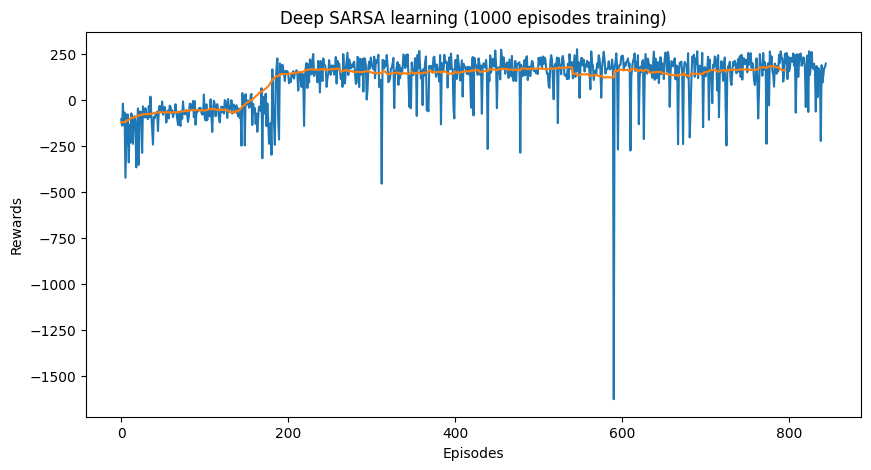

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reward_list_sarsa)
ax.plot(smas)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep SARSA learning (1000 episodes training)')
plt.savefig('images/Sarsa600epma.jpg')

In [ ]:
import pickle

In [ ]:
# torch.save(agent.qnetwork_local.state_dict(), 'saved_models/sarsa.pth')

In [ ]:
ep_600 = reward_list_sarsa
with open("saved_models/rewards_ep.txt", "wb") as fp:
    pickle.dump(ep_600, fp)

In [ ]:
with open("saved_models/rewards_ep.txt", "rb") as fp:
    imported = pickle.load(fp)

In [ ]:
smass = m_a(imported)

In [ ]:
# torch.save(agent.qnetwork_local.state_dict(), 'sarsa.pth')


# Deep Q Learning

In [ ]:
agent = DQNAgent(state_dim, action_dim)
number_of_episodes = 600
max_time_steps = 2000
reward_list = []
epsilon = 1
finals = []


for episode in range(number_of_episodes):
    reward_sum = 0
    state = env.reset()

    for _ in range(max_time_steps):
        action = agent.epsilon_greedy_action(torch.from_numpy(state).float() , epsilon)
        next_state, reward, terminal, _ = env.step(action)
        
        reward_sum += reward
        agent.replay_buffer.add_to_buffer((state,next_state,[action],[reward],[terminal]))
        state = next_state
        if terminal:
            clear_output(wait=True)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            reward_list.append(reward_sum)
            finals.append(reward)
            break
            
    agent.update(128)
    
    if epsilon > 0.2:
        epsilon *= 0.995 #Epsilon decay
    
    if epsilon <= 0.2:
        epsilon = 0.2

Linear(in_features=8, out_features=150, bias=True)


TypeError: expected np.ndarray (got tuple)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [ ]:
smas_ = m_a(reward_list)
# np.where(smas_> 100)


: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reward_list)
ax.plot(smas_)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep Q learning (600 episodes training)')
plt.savefig('DQN600epma', transparent=True)

: 

# Visualise the Model

In [ ]:
# state = env.reset()

# while True:
    
#     env.render()
#     action = agent.best_move(torch.from_numpy(state).float())
    
#     next_state, _, terminal, _ = env.step(action)
    
#     state = next_state
    
#     if terminal:
#         break
    
# env.close()

: 

### Creating DDQN

One of the flaws with a normal Deep Q-Network is that the DQN has a tendency to overestimate Q-values, which can hamper its performance in certain environments as the overestimation can result in a suboptimal policy of the agent.

To resolve this overestimation problem, it was proposed in [van Hasselt, Guez, and Silver, “Deep Reinforcement Learning with Double Q-Learning.”](http://arxiv.org/abs/1509.06461) to make use of the target network to calculate the Q-Values, while still using the online (non target) network for choosing actions(Both current and next action). As such, the evaluation of each action's Q Value and the selection of actions is decoupled.

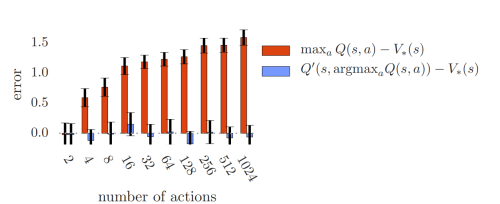

This results in reduced overestimation of the Q values, as shown in the above plot, where the error for the Double DQN update (in blue) is much smaller than that of the DQN update. 